In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
print(os.getcwd())
os.environ['HF_HOME'] = '/home/jovyan/shares/SR003.nfs2/.cache/huggingface'

/home/jovyan/shares/SR003.nfs2/kandi_video/vlad_test/RL


In [2]:
from torch import nn
import torch
from torch.nn import functional as F
import typing as tp
import datasets
from transformers import PreTrainedTokenizerFast, get_scheduler, GPT2Tokenizer
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from evaluate import load
import wandb
import matplotlib.pyplot as plt
import seaborn as sns

---

### Подготовка данных

In [3]:
dataset = datasets.load_dataset("wikitext", name="wikitext-2-raw-v1")

In [4]:
train_dataset, val_dataset = dataset['train'], dataset['validation']

In [5]:
train_dataset.num_rows, val_dataset.num_rows

(36718, 3760)

Фильтруем тексты, имеющие малую длину

In [6]:
train_dataset = train_dataset.filter(lambda x: len(x['text']) > 5)
val_dataset = val_dataset.filter(lambda x: len(x['text']) > 5)

In [7]:
train_dataset.num_rows, val_dataset.num_rows

(23726, 2461)

In [8]:
# дополнительная оптимизация 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.set_float32_matmul_precision('high')

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')

In [10]:
tokenizer.pad_token = tokenizer.eos_token

In [11]:
def collate_fn(samples: tp.List):
    outp = {'input_ids': [], 'attention_mask': []}
    for sample in samples:
        tokenize_text = tokenizer(sample['text'], max_length=1024, truncation=True, 
                          padding='max_length', return_token_type_ids=False, return_tensors='pt')
        outp['input_ids'].append(tokenize_text['input_ids'])
        outp['attention_mask'].append(tokenize_text['attention_mask'])
    outp['input_ids'] = torch.concat(outp['input_ids'])
    outp['attention_mask'] = torch.concat(outp['attention_mask'])
    return outp

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

---

### Обучение моделей

In [13]:
class QKV(nn.Module):
    def __init__(self, d_model, d_k, d_v):
        super().__init__()
        self.W_Q = nn.Linear(d_model, d_k, bias=False)
        self.W_K = nn.Linear(d_model, d_k, bias=False)
        self.W_V = nn.Linear(d_model, d_v, bias=False)
        nn.init.xavier_uniform_(self.W_Q.weight)
        nn.init.xavier_uniform_(self.W_K.weight)
        nn.init.xavier_uniform_(self.W_V.weight)
    
    def forward(self, X):
        Q = self.W_Q(X)
        K = self.W_K(X)
        V = self.W_V(X)
        return Q, K, V

In [14]:
class ConvAttnNet(nn.Module):
    def __init__(self, embedding_dim=384, hidden_dim=384):
        super().__init__()
        self.embeddings = nn.Embedding(num_embeddings=tokenizer.vocab_size, embedding_dim=embedding_dim)
        self.register_buffer('filter_mask', torch.tensor([1, 1, 0], dtype=torch.bool))
        self.conv = nn.Conv1d(embedding_dim, embedding_dim, 3, stride=1, padding=1)
        self.qkv = QKV(embedding_dim, hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, tokenizer.vocab_size)

    def forward(self, input_ids, attention_mask):
        embed = self.embeddings(input_ids).permute(0, 2, 1).contiguous() 
        conv_weight = self.conv.weight.data * self.filter_mask # не смотрим в будущее
        out = F.conv1d(embed, conv_weight, bias=self.conv.bias, stride=self.conv.stride, padding=self.conv.padding)
        out = out.permute(0, 2, 1).contiguous() 
        queries, keys, values = self.qkv(out)
        out = F.scaled_dot_product_attention(queries, keys, values, is_causal=True)
        return self.lm_head(out)
    

In [15]:
class AttnAttnNet(nn.Module):
    def __init__(self, embedding_dim=384, hidden_dim=384):
        super().__init__()
        self.embeddings = nn.Embedding(num_embeddings=tokenizer.vocab_size, embedding_dim=embedding_dim)
        self.qkv1 = QKV(embedding_dim, hidden_dim, hidden_dim)
        self.qkv2 = QKV(embedding_dim, hidden_dim, hidden_dim)
        self.lm_head = nn.Linear(hidden_dim, tokenizer.vocab_size)

    def forward(self, input_ids, attention_mask):
        embed = self.embeddings(input_ids)
        queries, keys, values = self.qkv1(embed)
        out = F.scaled_dot_product_attention(queries, keys, values, is_causal=True)
        queries, keys, values = self.qkv2(out)
        out = F.scaled_dot_product_attention(queries, keys, values, is_causal=True)
        return self.lm_head(out)
    

In [16]:
def train(model: nn.Module,
          name: str,
          train_dataloader: DataLoader = train_dataloader,
          val_dataloader: DataLoader = val_dataloader,
          lr: float = 3e-4,
          epochs: int = 10,
          scheduler_name: tp.Optional[str] = None,
          warmup_ratio: tp.Optional[float] = None
    ) -> tp.Tuple[nn.Module, tp.Dict[str, list]]:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    accuracy = load("accuracy")
    loss_fn = nn.CrossEntropyLoss(ignore_index=50256) # игнорируем индекс паддинга при подсчете лосса
    if scheduler_name:
        scheduler = get_scheduler(name=scheduler_name, optimizer=optimizer, num_warmup_steps=int(warmup_ratio * epochs * len(train_dataloader)),
                                  num_training_steps = epochs * len(train_dataloader))
    ep_vals = []
    ep_train = []
    ep_accuracies = []
    run = wandb.init(project='hw_induction_heads', name=name)
    run.watch(model)
    for ep in tqdm(range(epochs)):
        model.train()
        train_losses = []
        print('Train...')
        for e, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            batch = {k: v.to(device) for k,v in batch.items()}
            with torch.amp.autocast(dtype=torch.bfloat16, device_type='cuda'):
                outp = model(**batch)
                logits = outp[:, :-1, :]
                labels = batch['input_ids'][:, 1:].contiguous()
                loss = loss_fn(logits.permute(0, 2, 1).contiguous(), labels)
                loss.backward()
            
            train_losses.append(loss.item())
            wandb.log({'train/loss': loss.item(),
                      'train/lr': optimizer.param_groups[0]['lr']})
            if e % 100 == 0 and e != 0:
                print(f'Epoch: {ep+1}; iteration: {e} / {len(train_dataloader)}')
                print(np.mean(train_losses[:-20]))
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler_name:
                scheduler.step()
        ep_train.append(train_losses)
        
        print('Validation...')
        model.eval()
        val_losses = []
        accuracies = []
        for e, batch in enumerate(val_dataloader):
            batch = {k: v.to(device) for k,v in batch.items()}
            with torch.inference_mode(), torch.amp.autocast(dtype=torch.bfloat16, device_type='cuda'):
                outp = model(**batch)
                logits = outp[:, :-1, :]
                labels = batch['input_ids'][:, 1:].contiguous()
                loss = loss_fn(logits.permute(0, 2, 1).contiguous(), labels)
            # token_preds = outp[:, :-1, :].argmax(-1)
            shift_mask = batch["attention_mask"][:, 1:]
            mask_flat    = shift_mask.reshape(-1).bool().cpu() 
            preds_flat   = logits.argmax(-1).reshape(-1).cpu()                    
            labels_flat  = labels.reshape(-1).cpu()
            preds_filt  = preds_flat[mask_flat]        
            labels_filt = labels_flat[mask_flat]
            accuracy.add_batch(predictions=preds_filt.detach().numpy(),
                          references=labels_filt.detach().numpy())
            acc_dict = accuracy.compute()
            val_losses.append(loss.item())
            accuracies.append(acc_dict['accuracy'])
        wandb.log({'val/loss': np.mean(val_losses), 'val/accuracy': np.mean(accuracies)})
        print(f'Epoch: {ep+1}')
        print(np.mean(val_losses))
        print(np.mean(accuracies))
    ep_vals.append(val_losses)
    ep_accuracies.append(accuracies)
    results = {'train_losses': ep_train, 'val_losses': ep_vals, 'accuracies': ep_accuracies}
    wandb.finish()
    return model, results

In [18]:
conv_attn_model = ConvAttnNet().to(device)

In [19]:
conv_attn_model_trained, conv_attn_results = train(conv_attn_model, name='conv_attn_model', scheduler_name='cosine', warmup_ratio=0.1, epochs=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: v-veselov1 (vlad00k) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]

Train...
Epoch: 1; iteration: 100 / 742
10.819041617122696
Epoch: 1; iteration: 200 / 742
10.676888771478643
Epoch: 1; iteration: 300 / 742
9.816684926531916
Epoch: 1; iteration: 400 / 742
9.222614566172203
Epoch: 1; iteration: 500 / 742
8.843455605100445
Epoch: 1; iteration: 600 / 742
8.582297252911093
Epoch: 1; iteration: 700 / 742
8.38707676508003
Validation...


 10%|█         | 1/10 [04:57<44:35, 297.27s/it]

Epoch: 1
7.1356966774184984
0.1145730609105226
Train...
Epoch: 2; iteration: 100 / 742
7.03366529205699
Epoch: 2; iteration: 200 / 742
6.991350007979251
Epoch: 2; iteration: 300 / 742
6.956719423952476
Epoch: 2; iteration: 400 / 742
6.920056862468169
Epoch: 2; iteration: 500 / 742
6.886965015078285
Epoch: 2; iteration: 600 / 742
6.85916406316314
Epoch: 2; iteration: 700 / 742
6.835524659149797
Validation...


 20%|██        | 2/10 [09:48<39:11, 293.92s/it]

Epoch: 2
6.708701839694729
0.14522918432890475
Train...
Epoch: 3; iteration: 100 / 742
6.580430024935875
Epoch: 3; iteration: 200 / 742
6.573773276081401
Epoch: 3; iteration: 300 / 742
6.562549392523715
Epoch: 3; iteration: 400 / 742
6.541974348033194
Epoch: 3; iteration: 500 / 742
6.519328588259691
Epoch: 3; iteration: 600 / 742
6.5047877142638635
Epoch: 3; iteration: 700 / 742
6.487671735178181
Validation...


 30%|███       | 3/10 [14:40<34:09, 292.81s/it]

Epoch: 3
6.497640547814307
0.15587819427420269
Train...
Epoch: 4; iteration: 100 / 742
6.2680598306067195
Epoch: 4; iteration: 200 / 742
6.2518856090735335
Epoch: 4; iteration: 300 / 742
6.2387410041700475
Epoch: 4; iteration: 400 / 742
6.231637589261913
Epoch: 4; iteration: 500 / 742
6.221097726088304
Epoch: 4; iteration: 600 / 742
6.20948333953621
Epoch: 4; iteration: 700 / 742
6.200108132523412
Validation...


 40%|████      | 4/10 [19:31<29:13, 292.30s/it]

Epoch: 4
6.361655829788803
0.16482587694056103
Train...
Epoch: 5; iteration: 100 / 742
6.011497497558594
Epoch: 5; iteration: 200 / 742
6.00485198932458
Epoch: 5; iteration: 300 / 742
6.003369248210324
Epoch: 5; iteration: 400 / 742
5.997460021121609
Epoch: 5; iteration: 500 / 742
5.989473404358925
Epoch: 5; iteration: 600 / 742
5.9871376853391345
Epoch: 5; iteration: 700 / 742
5.98090522264769
Validation...


 50%|█████     | 5/10 [24:23<24:19, 291.94s/it]

Epoch: 5
6.27983012756744
0.1702332391952007
Train...
Epoch: 6; iteration: 100 / 742
5.8455243287263094
Epoch: 6; iteration: 200 / 742
5.841131710874442
Epoch: 6; iteration: 300 / 742
5.82705564940103
Epoch: 6; iteration: 400 / 742
5.824341021810617
Epoch: 6; iteration: 500 / 742
5.821992337827623
Epoch: 6; iteration: 600 / 742
5.818443322961384
Epoch: 6; iteration: 700 / 742
5.81644916114303
Validation...


 60%|██████    | 6/10 [29:14<19:26, 291.74s/it]

Epoch: 6
6.229428049805876
0.17551611322699034
Train...
Epoch: 7; iteration: 100 / 742
5.7158040941497426
Epoch: 7; iteration: 200 / 742
5.706702672315566
Epoch: 7; iteration: 300 / 742
5.707219057660086
Epoch: 7; iteration: 400 / 742
5.705400451900452
Epoch: 7; iteration: 500 / 742
5.706588171128176
Epoch: 7; iteration: 600 / 742
5.704628978867128
Epoch: 7; iteration: 700 / 742
5.700378387159888
Validation...


 70%|███████   | 7/10 [34:05<14:34, 291.43s/it]

Epoch: 7
6.204480462260061
0.17752594701085078
Train...
Epoch: 8; iteration: 100 / 742
5.626069763560354
Epoch: 8; iteration: 200 / 742
5.630276319071733
Epoch: 8; iteration: 300 / 742
5.628696628312623
Epoch: 8; iteration: 400 / 742
5.632953663823486
Epoch: 8; iteration: 500 / 742
5.632580800760313
Epoch: 8; iteration: 600 / 742
5.6299139497202155
Epoch: 8; iteration: 700 / 742
5.629430934020951
Validation...


 80%|████████  | 8/10 [38:54<09:41, 290.82s/it]

Epoch: 8
6.1937002144850695
0.17917214523014377
Train...
Epoch: 9; iteration: 100 / 742
5.572852770487468
Epoch: 9; iteration: 200 / 742
5.584899638897806
Epoch: 9; iteration: 300 / 742
5.58675943320332
Epoch: 9; iteration: 400 / 742
5.584710363953758
Epoch: 9; iteration: 500 / 742
5.585303903369547
Epoch: 9; iteration: 600 / 742
5.586940173643181
Epoch: 9; iteration: 700 / 742
5.586985074826099
Validation...


 90%|█████████ | 9/10 [43:45<04:50, 290.69s/it]

Epoch: 9
6.190435694409655
0.1795445051256482
Train...
Epoch: 10; iteration: 100 / 742
5.562801031418789
Epoch: 10; iteration: 200 / 742
5.56149856556845
Epoch: 10; iteration: 300 / 742
5.568538906735458
Epoch: 10; iteration: 400 / 742
5.565271646644812
Epoch: 10; iteration: 500 / 742
5.567432470975943
Epoch: 10; iteration: 600 / 742
5.570639348481485
Epoch: 10; iteration: 700 / 742
5.57034300007309
Validation...


100%|██████████| 10/10 [48:35<00:00, 291.53s/it]

Epoch: 10
6.190169167208981
0.17990099942637908


train/loss,█▇▇▆▆▆▅▄▄▄▃▄▃▄▃▃▂▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▂▁▂
train/lr,▃▅▆████████████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▂▂▂▂▁▁▁▁▁
val/accuracy,▁▄▅▆▇█████
val/loss,█▅▃▂▂▁▁▁▁▁
train/loss,5.29239
train/lr,0.0
val/accuracy,0.1799
val/loss,6.19017


In [20]:
torch.save(conv_attn_model_trained, 'conv_attn_model_trained_wiki2.pth')

In [ ]:
attn_attn_model = AttnAttnNet().to(device)
attn_attn_model_trained, attn_attn_results = train(attn_attn_model, name='attn_attn_model', scheduler_name='cosine', warmup_ratio=0.1, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train...
Epoch: 1; iteration: 100 / 742
10.785077236316821
Epoch: 1; iteration: 200 / 742
9.582916478425759
Epoch: 1; iteration: 300 / 742
8.882044703934964
Epoch: 1; iteration: 400 / 742
8.510095521221011
Epoch: 1; iteration: 500 / 742
8.25997122806224
Epoch: 1; iteration: 600 / 742
8.070466205708541
Epoch: 1; iteration: 700 / 742
7.92962552447326
Validation...


 10%|█         | 1/10 [04:55<44:17, 295.28s/it]

Epoch: 1
7.097301179712469
0.11388219892281155
Train...
Epoch: 2; iteration: 100 / 742
6.988108111016544
Epoch: 2; iteration: 200 / 742
6.977359587316355
Epoch: 2; iteration: 300 / 742
6.952973771349815
Epoch: 2; iteration: 400 / 742
6.937199283459681
Epoch: 2; iteration: 500 / 742
6.91656138644149
Epoch: 2; iteration: 600 / 742
6.900317846189883
Epoch: 2; iteration: 700 / 742
6.882849433523618
Validation...


 20%|██        | 2/10 [09:50<39:19, 294.97s/it]

Epoch: 2
6.829522170029677
0.12369179886003526
Train...
Epoch: 3; iteration: 100 / 742
6.6607170811405885
Epoch: 3; iteration: 200 / 742
6.657883322699952
Epoch: 3; iteration: 300 / 742
6.651604491196493
Epoch: 3; iteration: 400 / 742
6.6458386911807725
Epoch: 3; iteration: 500 / 742
6.635929566658956
Epoch: 3; iteration: 600 / 742
6.634118001350232
Epoch: 3; iteration: 700 / 742
6.626865195807906
Validation...


 30%|███       | 3/10 [14:45<34:26, 295.17s/it]

Epoch: 3
6.724346507679332
0.13096313898063597
Train...
Epoch: 4; iteration: 100 / 742
6.46223207756325
Epoch: 4; iteration: 200 / 742
6.463233802858637
Epoch: 4; iteration: 300 / 742
6.4668335982489
Epoch: 4; iteration: 400 / 742
6.461652954732339
Epoch: 4; iteration: 500 / 742
6.457906338380429
Epoch: 4; iteration: 600 / 742
6.455117553113455
Epoch: 4; iteration: 700 / 742
6.448510959810097
Validation...


 40%|████      | 4/10 [19:40<29:31, 295.25s/it]

Epoch: 4
6.652481110065015
0.13384510576753927
Train...
Epoch: 5; iteration: 100 / 742
6.30230885376165
Epoch: 5; iteration: 200 / 742
6.322387097290208
Epoch: 5; iteration: 300 / 742
6.31547531962819
Epoch: 5; iteration: 400 / 742
6.31528204194517
Epoch: 5; iteration: 500 / 742
6.313016388867353
Epoch: 5; iteration: 600 / 742
6.3096915834331675
Epoch: 5; iteration: 700 / 742
6.306891714423764
Validation...


 50%|█████     | 5/10 [24:35<24:35, 295.05s/it]

Epoch: 5
6.614582699614686
0.14105825418143622
Train...
Epoch: 6; iteration: 100 / 742
6.202436906320077
Epoch: 6; iteration: 200 / 742
6.208850133484899
Epoch: 6; iteration: 300 / 742
6.2058065692725135
Epoch: 6; iteration: 400 / 742
6.200251117466003
Epoch: 6; iteration: 500 / 742
6.199637949342788
Epoch: 6; iteration: 600 / 742
6.201975838042372
Epoch: 6; iteration: 700 / 742
6.201618011827511
Validation...


 60%|██████    | 6/10 [29:29<19:38, 294.75s/it]

Epoch: 6
6.595625827838848
0.14387882435345006
Train...
Epoch: 7; iteration: 100 / 742
6.111778594829418
Epoch: 7; iteration: 200 / 742
6.121284384753823
Epoch: 7; iteration: 300 / 742
6.119307017411201
Epoch: 7; iteration: 400 / 742
6.121555214478901
Epoch: 7; iteration: 500 / 742
6.121376762271176
Epoch: 7; iteration: 600 / 742
6.118917379034571
Epoch: 7; iteration: 700 / 742
6.117836309424581
Validation...


 70%|███████   | 7/10 [34:23<14:43, 294.52s/it]

Epoch: 7
6.587796694272525
0.1447668769792513
Train...
Epoch: 8; iteration: 100 / 742
6.034773261458786
Epoch: 8; iteration: 200 / 742
6.041594510578977
Epoch: 8; iteration: 300 / 742
6.046387623213364
Epoch: 8; iteration: 400 / 742
6.048401409559675
Epoch: 8; iteration: 500 / 742
6.049006483906767
Epoch: 8; iteration: 600 / 742
6.053229131715023
Epoch: 8; iteration: 700 / 742
6.054638679157095


In [ ]:
torch.save(attn_attn_model_trained, 'attn_attn_model_trained_wiki2.pth')

---

In [17]:
conv_attn_model_trained = torch.load('conv_attn_model_trained_wiki2.pth').to(device)
conv_attn_model_trained.eval();

/tmp/ipykernel_18161/567732281.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv_attn_model_trained = torch.load('conv_attn_model_trained_wiki2.pth').to(device)


In [18]:
attn_attn_model_trained = torch.load('attn_attn_model_trained_wiki2.pth').to(device)
attn_attn_model_trained.eval();

/tmp/ipykernel_18161/2474178985.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_attn_model_trained = torch.load('attn_attn_model_trained_wiki2.pth').to(device)


### Эксперименты

In [21]:
conv_weights = conv_attn_model_trained.conv.weight.detach().cpu()

Посмотрим на heatmap полученных весов в разрезе фичей.

Фича №1 Статистики по весам
max:  0.12856468558311462
min:  -0.13582980632781982
q75:  0.021226908545941114
q90:  0.039349984377622604
Фича №2 Статистики по весам
max:  0.1751350611448288
min:  -0.1805594116449356
q75:  0.025916107464581728
q90:  0.048843568190932274
Фича №3 Статистики по весам
max:  0.02897469699382782
min:  -0.02897481992840767
q75:  0.01450201845727861
q90:  0.02313644252717495


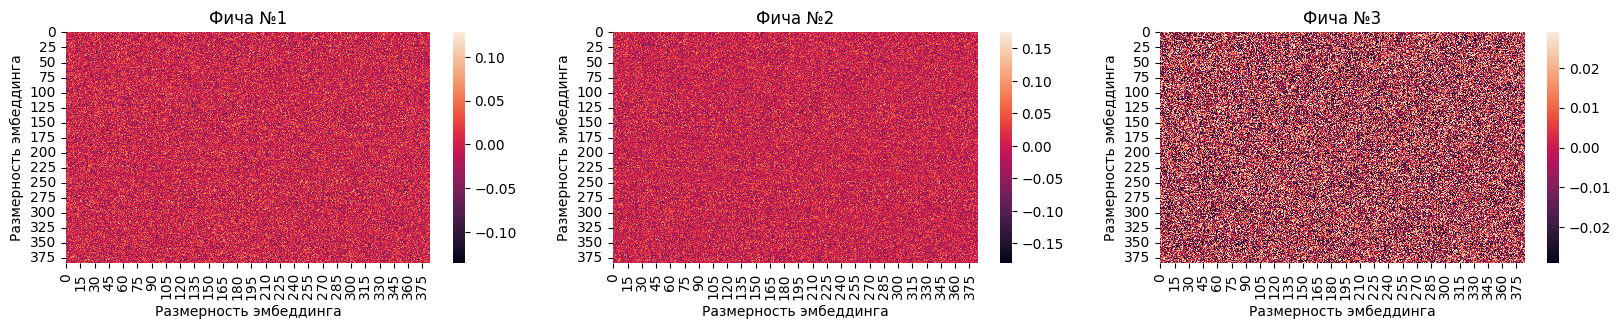

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3))
for i in range(3):
    ax = axes[i]
    sns.heatmap(conv_weights[:, :, i], ax=ax)
    ax.set_title(f'Фича №{i+1}')
    ax.set_xlabel('Размерность эмбеддинга')
    ax.set_ylabel('Размерность эмбеддинга')
    print(f'Фича №{i+1} Статистики по весам')
    print('max: ', conv_weights[:, :, i].max().item())
    print('min: ', conv_weights[:, :, i].min().item())
    print('q75: ', np.quantile(conv_weights[:, :, i], 0.75))
    print('q90: ', np.quantile(conv_weights[:, :, i], 0.90))

In [23]:
fig.savefig('Feature_map.png')

Посмотрим на активации весов в фильтрах, для наглядности, ограничимся пятью. Для контрастности значений, будем смотреть на абсолютные значения.

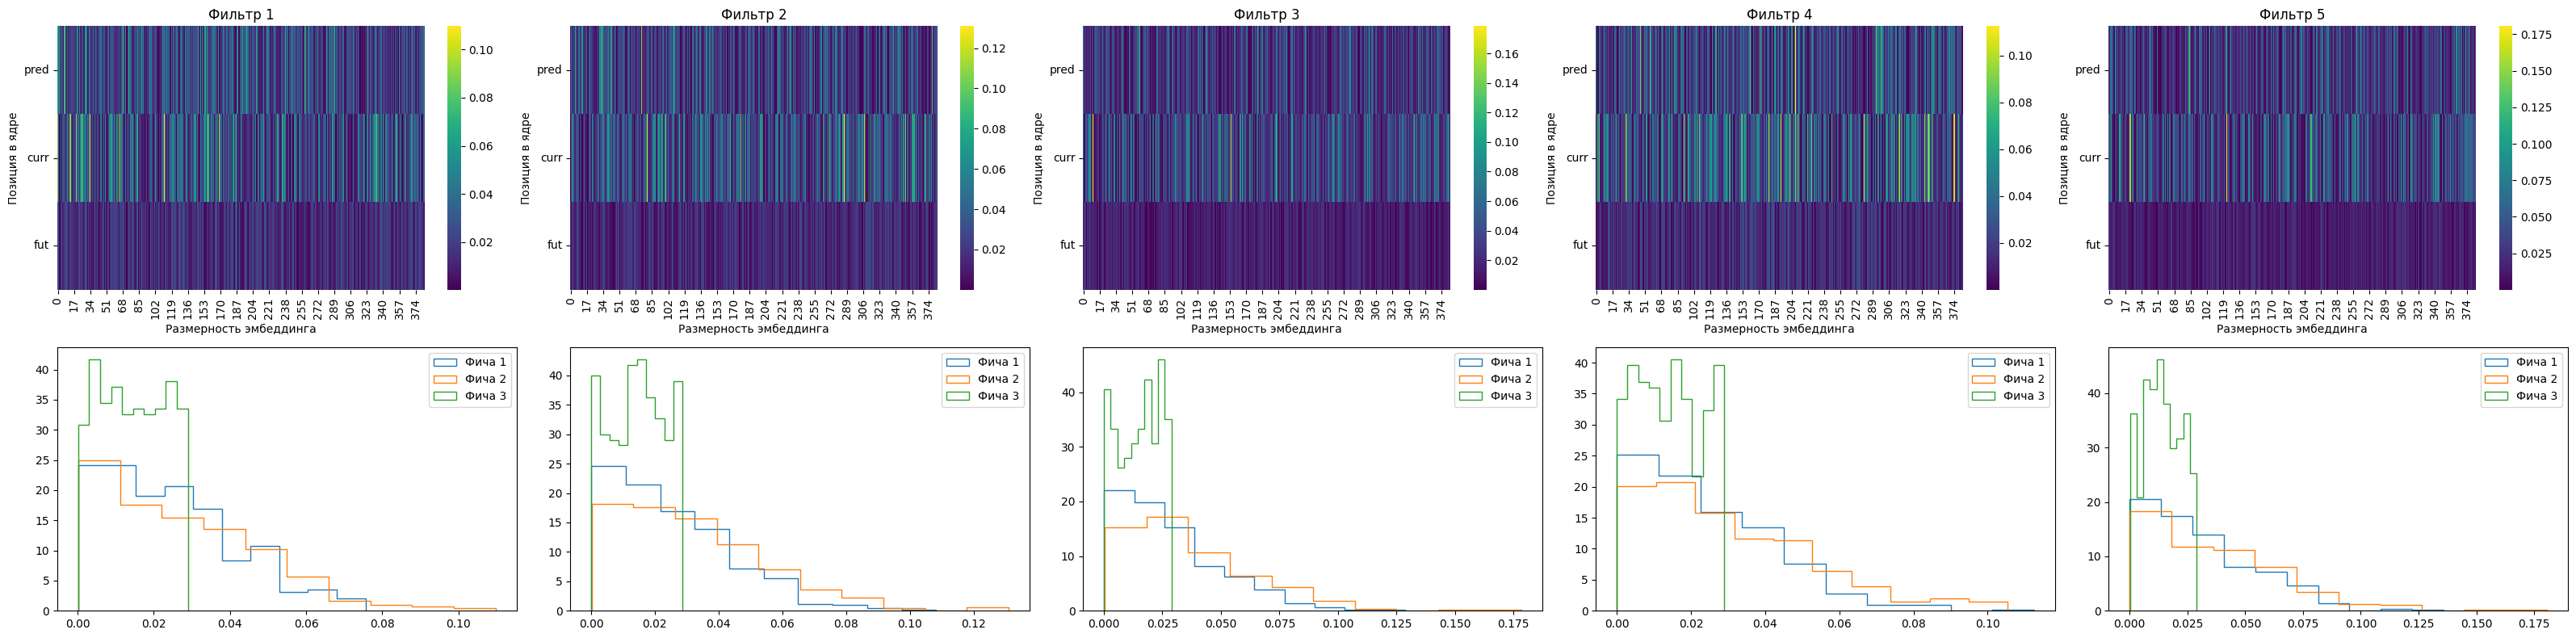

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

N = 5
fig, axes = plt.subplots(2, N, figsize=(32, 8))
perm_conv_weights = conv_weights.permute(0, 2, 1)
for i in range(N):
    ax1 = axes[0][i]
    ax2 = axes[1][i]
    sns.heatmap(perm_conv_weights[i].abs(), cmap='viridis', cbar=True, ax=ax1)
    for j in range(3):
        ax2.hist(conv_weights[i, :, j].abs().flatten(), histtype=u'step', density=True, label=f'Фича {j+1}')
        ax2.legend()
    ax1.set_title(f'Фильтр {i+1}')
    ax1.set_xlabel('Размерность эмбеддинга')
    ax1.set_ylabel('Позиция в ядре')
    ax1.set_yticklabels(['pred', 'curr', 'fut'], rotation=0)
plt.tight_layout()
plt.show()


In [25]:
fig.savefig('smeared_keys.png')

In [26]:
for i in range(N):
    print(f'Фильтр №{i+1}.')
    for j in range(3):
        print(f'    Фича №{j+1}.')
        print('    max: ', conv_weights[i, :, j].abs().max().item())
        print('    min: ', conv_weights[i, :, j].abs().min().item())
        print('    mean: ', conv_weights[i, :, j].abs().mean().item())
        print('    std: ', conv_weights[i, :, j].abs().std().item())

Фильтр №1.
    Фича №1.
    max:  0.07557351142168045
    min:  0.00018473295494914055
    mean:  0.024804843589663506
    std:  0.017036398872733116
    Фича №2.
    max:  0.1097520962357521
    min:  0.0002142401790479198
    mean:  0.02757279761135578
    std:  0.020765788853168488
    Фича №3.
    max:  0.028959551826119423
    min:  0.00019250974582973868
    mean:  0.014525755308568478
    std:  0.008308456279337406
Фильтр №2.
    Фича №1.
    max:  0.10821399837732315
    min:  3.931009632651694e-05
    mean:  0.025406939908862114
    std:  0.019081195816397667
    Фича №2.
    max:  0.1309191733598709
    min:  0.0002137420087819919
    mean:  0.032115835696458817
    std:  0.023224739357829094
    Фича №3.
    max:  0.028691964223980904
    min:  3.5056891647400334e-06
    mean:  0.014471965841948986
    std:  0.0083095021545887
Фильтр №3.
    Фича №1.
    max:  0.12856468558311462
    min:  8.610171062173322e-05
    mean:  0.028866305947303772
    std:  0.022031137719750404
 

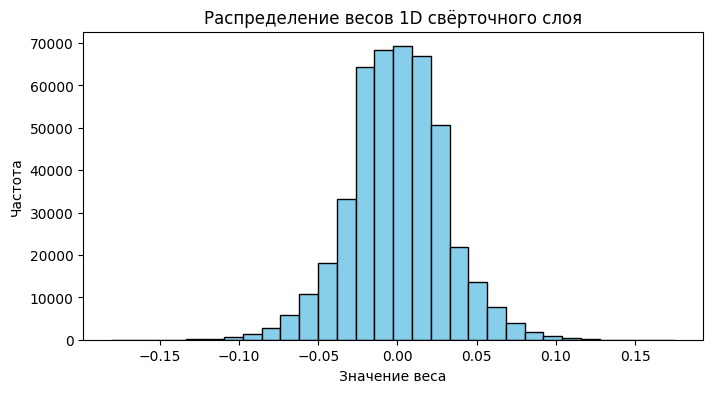

In [27]:
plt.figure(figsize=(8, 4))
all_weights = conv_weights.view(-1)
plt.hist(all_weights, bins=30, color="skyblue", edgecolor="black")
plt.title("Распределение весов 1D свёрточного слоя")
plt.xlabel("Значение веса")
plt.ylabel("Частота")
plt.savefig('distrib.png')
plt.show()

### Induction heads

In [55]:
text = """Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much."""\
"""They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense."""\
"""Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much."""

In [56]:
enc = tokenizer(text, return_token_type_ids=False, return_tensors='pt', padding='max_length', max_length=2048).to(device)

In [57]:
conv_weight = conv_attn_model_trained.conv.weight.detach() * conv_attn_model_trained.filter_mask.detach()

In [58]:
embed = conv_attn_model_trained.embeddings(enc['input_ids']).permute(0, 2, 1) 

In [59]:
out = F.conv1d(embed, conv_weight, bias=conv_attn_model_trained.conv.bias,
                                   stride=conv_attn_model_trained.conv.stride,
                                   padding=conv_attn_model_trained.conv.padding)
out = out.permute(0, 2, 1) 
queries, keys, values = conv_attn_model_trained.qkv(out)

In [60]:
def get_attn_weights(model: nn.Module, enc: tp.Dict[str, torch.Tensor], name: str) -> tp.Tuple:
    if name == 'conv_attn_model':
        embed = model.embeddings(enc['input_ids']).permute(0, 2, 1) 
        conv_weight = model.conv.weight * model.filter_mask.view(1, 1, -1) # не смотрим в будущее
        out = F.conv1d(embed, conv_weight, bias=model.conv.bias,
                                           stride=model.conv.stride,
                                           padding=model.conv.padding)
        out = out.permute(0, 2, 1) 
        queries, keys, values = model.qkv(out)
        return queries, keys, values
    elif name == 'attn_attn_model':
        embed = model.embeddings(enc['input_ids'])
        queries1, keys1, values1 = model.qkv1(embed)
        out = F.scaled_dot_product_attention(queries1, keys1, values1, attn_mask=enc['attention_mask'].unsqueeze(-1).bool())
        queries2, keys2, values2 = model.qkv2(out)
        return (queries1, keys1, values1), (queries2, keys2, values2)
        

In [61]:
(queries1, keys1, values1), (queries2, keys2, values2) = get_attn_weights(attn_attn_model_trained, enc, 'attn_attn_model')

In [62]:
queries, keys, values = get_attn_weights(conv_attn_model_trained, enc, 'conv_attn_model')

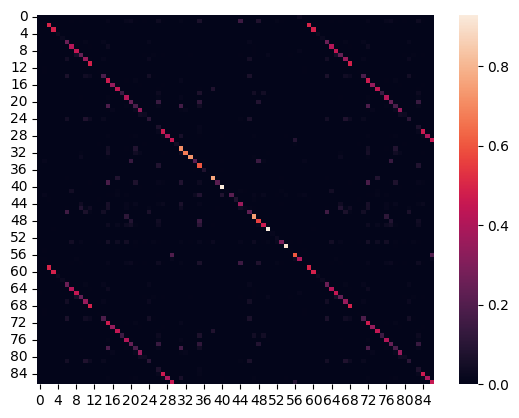

In [73]:
sns.heatmap((queries[0] @ keys[0].T / np.sqrt(384)).softmax(-1).detach().cpu().numpy()[:87, :87])
plt.savefig('conv_attn_attention.png')

<Axes: >

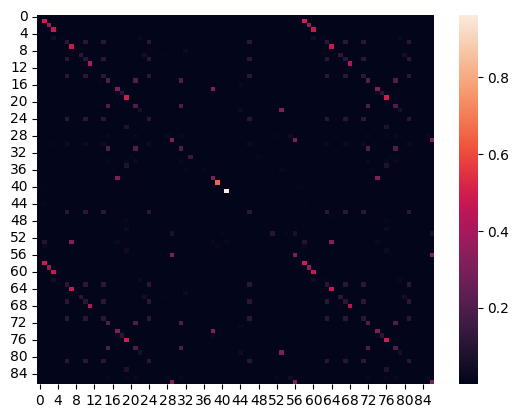

In [70]:
sns.heatmap((queries1[0] @ keys1[0].T / np.sqrt(512)).softmax(-1).detach().cpu().numpy()[:87, :87])

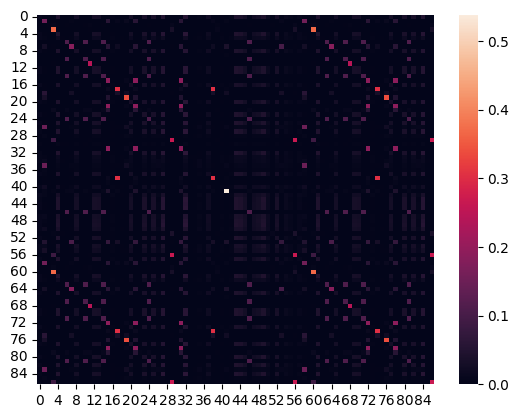

In [74]:
sns.heatmap((queries2[0] @ keys2[0].T / np.sqrt(512)).softmax(-1).detach().cpu().numpy()[:87, :87])
plt.savefig('attn_attn_attention.png')

In [121]:
out = conv_attn_model_trained(**enc)

In [122]:
attn_mask = enc['attention_mask'].detach().cpu()

In [123]:
enc['input_ids'].shape

torch.Size([1, 2048])

In [124]:
tokens = [tokenizer.decode(tok, clean_up_tokenization_spaces=False) for tok in enc['input_ids'][0, 1:][attn_mask.squeeze()[1:] == 1]]

In [134]:
tok_weights = torch.zeros((86,), dtype=torch.float32)

In [135]:
weights = out[0].cpu().detach()
act_weights = weights[attn_mask.squeeze() == 1, :][:-1]

In [136]:
act_weights.shape, len(tokens)

(torch.Size([86, 50257]), 86)

In [137]:
#weights.shape # predicted tokens
#enc['input_ids'] # current tokens
# enc['input_ids'][1:] # next tokens

# tok_weights needed tokens next weights

In [138]:
for j, i in enumerate(enc['input_ids'][0, 1:][attn_mask.squeeze()[1:] == 1].cpu()):
    print(j, i.item())
    tok_weights[j]=act_weights[j].softmax(-1)[i.item()]

0 290
1 9074
2 360
3 1834
4 1636
5 11
6 286
7 1271
8 1440
9 11
10 4389
11 16809
12 9974
13 11
14 547
15 6613
16 284
17 910
18 326
19 484
20 547
21 7138
22 3487
23 11
24 5875
25 345
26 845
27 881
28 13
29 2990
30 547
31 262
32 938
33 661
34 345
35 1549
36 1607
37 284
38 307
39 2950
40 287
41 1997
42 6283
43 393
44 11428
45 11
46 780
47 484
48 655
49 1422
50 470
51 1745
52 351
53 884
54 18149
55 13
56 5246
57 290
58 9074
59 360
60 1834
61 1636
62 11
63 286
64 1271
65 1440
66 11
67 4389
68 16809
69 9974
70 11
71 547
72 6613
73 284
74 910
75 326
76 484
77 547
78 7138
79 3487
80 11
81 5875
82 345
83 845
84 881
85 13


In [139]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from IPython.display import display, HTML

def render_colored_text(text, weights, cmap_name='Reds'):
    norm = mcolors.Normalize(vmin=0, vmax=tok_weights.max())
    cmap = cm.get_cmap(cmap_name)
    
    html_result = ""
    
    for token, weight in zip(tokens, weights):
        rgba = cmap(norm(weight))
        r, g, b, _ = rgba
        hex_color = f'#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}'

        html_result += f'<span style="background-color: {hex_color}; padding: 2px; margin: 2px;">{token}</span> '
    
    return html_result

# Пример текста
colored_html = render_colored_text(text, tok_weights, cmap_name='Reds')
display(HTML(colored_html))
with open("colored_text.html", "w", encoding="utf-8") as f:
    f.write(f"<html><body>{colored_html}</body></html>")


/tmp/ipykernel_18161/4046438264.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
